In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path('../src').resolve()))
import os
import pickle
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from adjustText import adjust_text
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
from sklearn.base import clone
from sklearn.metrics import silhouette_score
from preprocessing import BagOfNotes, BagOfChords2, NfIsf, PreprocessMidiDataFrame, MidiPathToDataFrame, MidiPathToPrettyMidi,InstrumentAwareBoN
import evaluation

In [ ]:
maestro_path = Path('../maestro/maestro-v3.0.0/')
df = pd.read_csv('../eda/no_dups.csv')
train = df[df.split == 'train']
validate = df[df.split == 'validation']

pipe = Pipeline([
    ('loader', MidiPathToDataFrame(maestro_path)),
    ('cleaner', PreprocessMidiDataFrame()),
])
train_loaded = pipe.transform(train.midi_filename)
val_loaded = pipe.transform(validate.midi_filename)

pretty_train = MidiPathToPrettyMidi(maestro_path).transform(train.midi_filename)
pretty_val = MidiPathToPrettyMidi(maestro_path).transform(validate.midi_filename)

In [ ]:
bitmidi_folder = Path('../data/')
bitmidi_files = [f for f in os.listdir(bitmidi_folder) if f.endswith(".mid")]
bitmidi_raw = Pipeline([
    ('loader', MidiPathToDataFrame(bitmidi_folder)),
    ('cleaner', PreprocessMidiDataFrame())
]).transform(bitmidi_files)
bitmidi_pretty = MidiPathToPrettyMidi(bitmidi_folder).transform(bitmidi_files)

In [49]:
vectorizers = [
    ('BoN', BagOfNotes(normalize=False)),
    ('BoNn', BagOfNotes(normalize=True)),
    ('NfIsf', NfIsf()),
    ('BoC2', BagOfChords2(time_threshold=30)),
    ('InstBoN', InstrumentAwareBoN())
]

In [50]:
X_vec_test = BagOfNotes(normalize=True).fit_transform(train_loaded)
scores = {}
for n in range(6, 36, 3):
    iso = Isomap(n_neighbors=n, n_components=2)
    X_iso = iso.fit_transform(X_vec_test)
    kmeans = KMeans(n_clusters=20, random_state=42)
    labels = kmeans.fit_predict(X_iso)
    scores[n] = silhouette_score(X_iso, labels)
    print(f"n_neighbors={n}, silhouette={scores[n]:.4f}")
best_n = max(scores, key=scores.get)

n_neighbors=6, silhouette=0.4004
n_neighbors=9, silhouette=0.4004
n_neighbors=12, silhouette=0.3918
n_neighbors=15, silhouette=0.3831
n_neighbors=18, silhouette=0.3925
n_neighbors=21, silhouette=0.4014
n_neighbors=24, silhouette=0.4083
n_neighbors=27, silhouette=0.3957
n_neighbors=30, silhouette=0.3977
n_neighbors=33, silhouette=0.3862


In [51]:
X_iso = Isomap(n_neighbors=best_n, n_components=2).fit_transform(X_vec_test)
k_scores = {}
for k in range(2, 31):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_iso)
    k_scores[k] = silhouette_score(X_iso, labels)
    print(f"k={k}, silhouette={k_scores[k]:.4f}")
best_k = max(k_scores, key=k_scores.get)

k=2, silhouette=0.3704
k=3, silhouette=0.3943
k=4, silhouette=0.3474
k=5, silhouette=0.3731
k=6, silhouette=0.3782
k=7, silhouette=0.3547
k=8, silhouette=0.3767
k=9, silhouette=0.3883
k=10, silhouette=0.3981
k=11, silhouette=0.3971
k=12, silhouette=0.4034
k=13, silhouette=0.3941
k=14, silhouette=0.3899
k=15, silhouette=0.3873
k=16, silhouette=0.3947
k=17, silhouette=0.4032
k=18, silhouette=0.4099
k=19, silhouette=0.4017
k=20, silhouette=0.4083
k=21, silhouette=0.3973
k=22, silhouette=0.3991
k=23, silhouette=0.3947
k=24, silhouette=0.3956
k=25, silhouette=0.3902
k=26, silhouette=0.3924
k=27, silhouette=0.3923
k=28, silhouette=0.3964
k=29, silhouette=0.3913
k=30, silhouette=0.4010


In [52]:
reducers = [
    ('PCA2', PCA(n_components=2)),
    ('Iso2', Isomap(n_neighbors=best_n, n_components=2)),
]

In [53]:
clusterers = [
    ('kmeans', KMeans(n_clusters=best_k, random_state=33))
]

Running: BoN-PCA2-kmeans


/var/folders/_3/z0_712995xv71srz8s868tkh0000gn/T/ipykernel_34798/3424943048.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


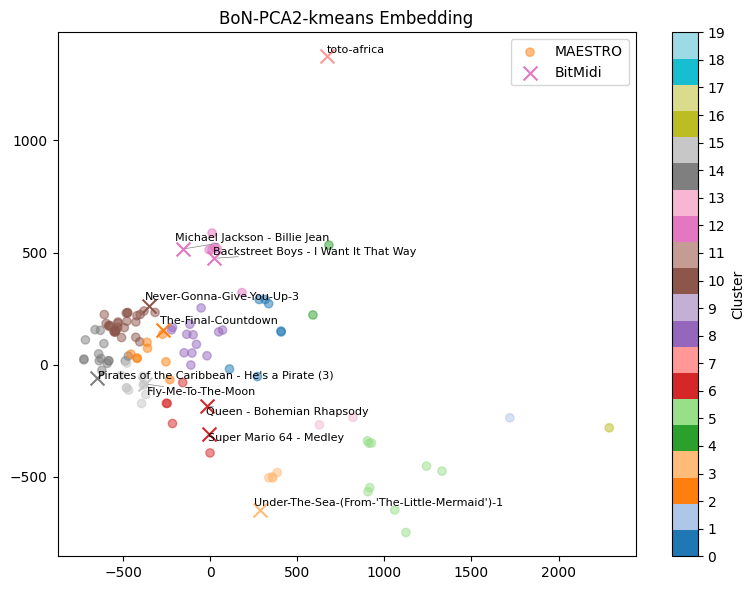

Running: BoN-Iso2-kmeans


/var/folders/_3/z0_712995xv71srz8s868tkh0000gn/T/ipykernel_34798/3424943048.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


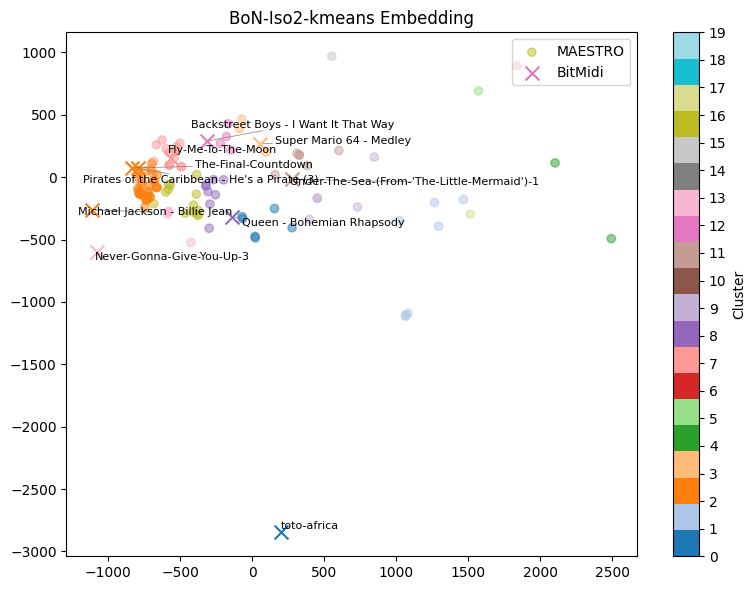

Running: BoNn-PCA2-kmeans


/var/folders/_3/z0_712995xv71srz8s868tkh0000gn/T/ipykernel_34798/3424943048.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


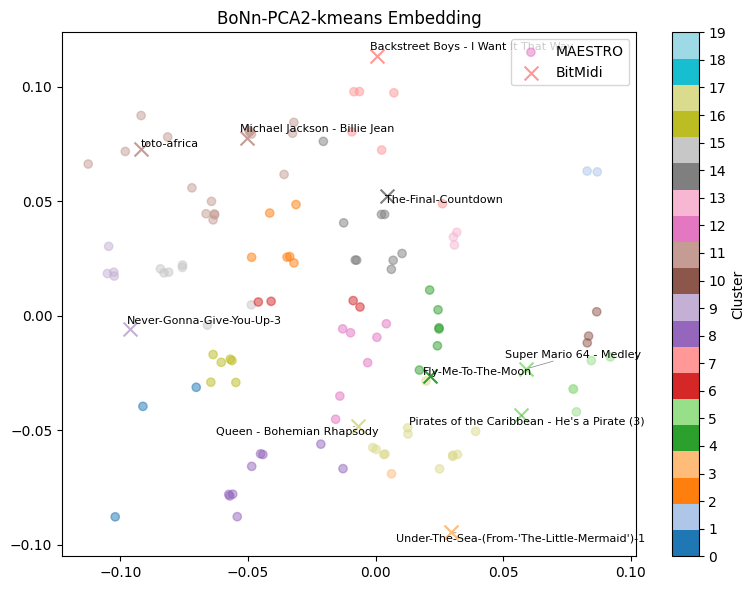

Running: BoNn-Iso2-kmeans


/var/folders/_3/z0_712995xv71srz8s868tkh0000gn/T/ipykernel_34798/3424943048.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


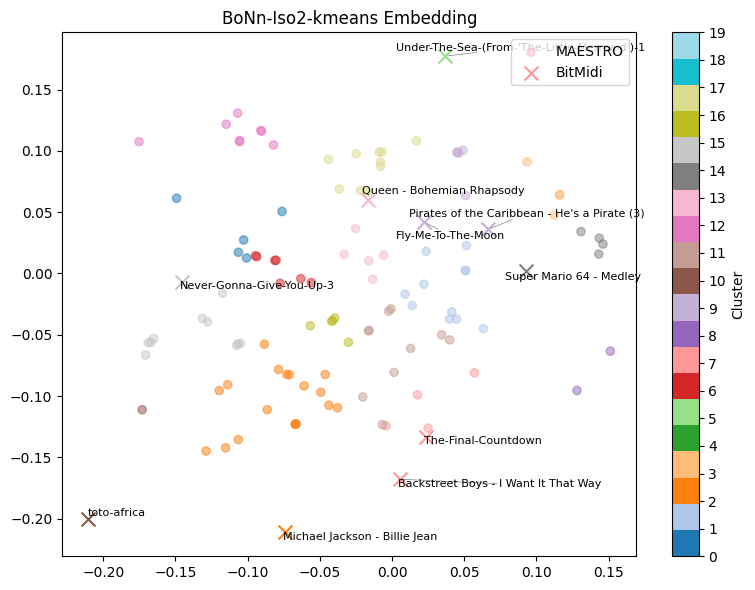

Running: NfIsf-PCA2-kmeans


/var/folders/_3/z0_712995xv71srz8s868tkh0000gn/T/ipykernel_34798/3424943048.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


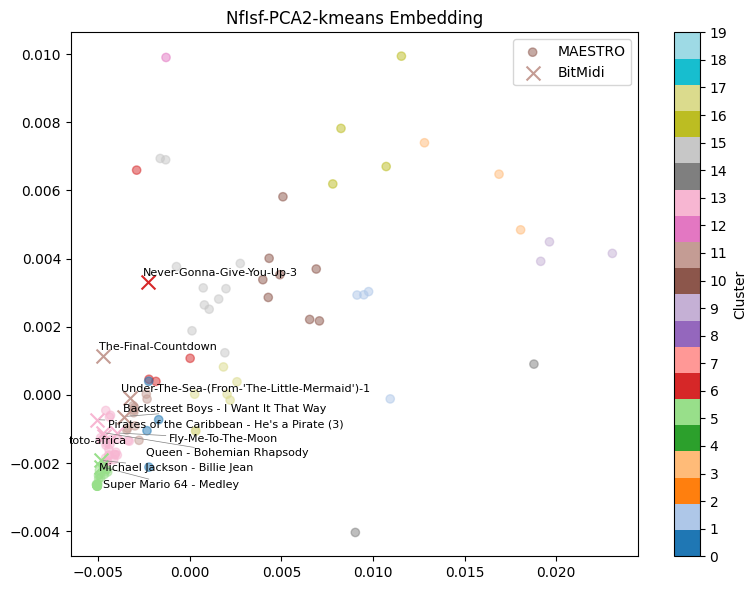

Running: NfIsf-Iso2-kmeans


/var/folders/_3/z0_712995xv71srz8s868tkh0000gn/T/ipykernel_34798/3424943048.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


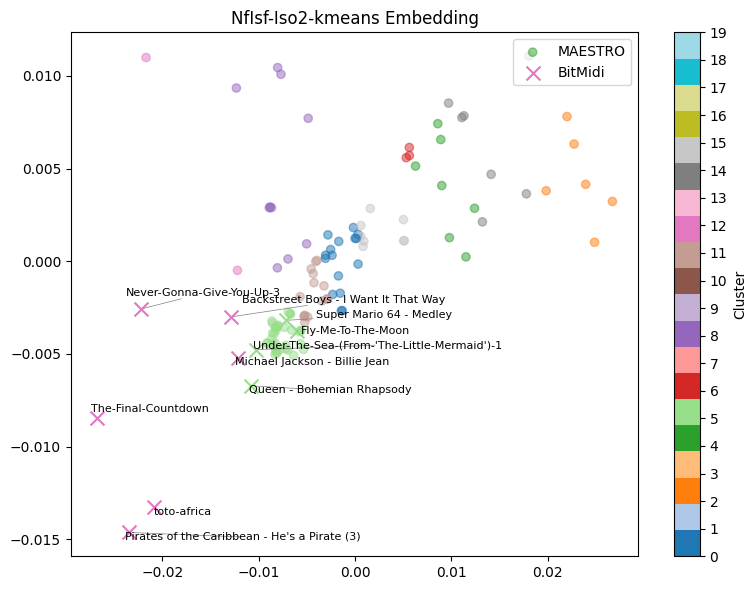

Running: BoC2-PCA2-kmeans


/var/folders/_3/z0_712995xv71srz8s868tkh0000gn/T/ipykernel_34798/3424943048.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


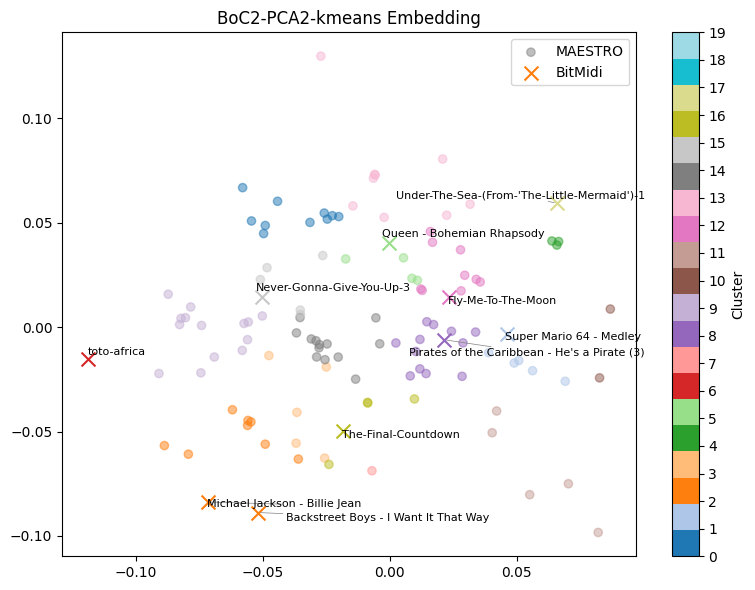

Running: BoC2-Iso2-kmeans


/var/folders/_3/z0_712995xv71srz8s868tkh0000gn/T/ipykernel_34798/3424943048.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


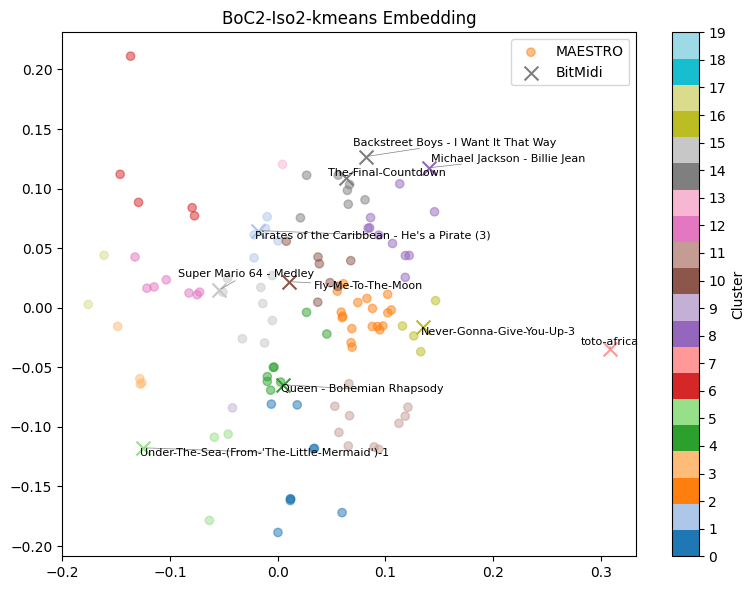

Running: InstBoN-PCA2-kmeans
1 [0.88735525 0.99512014]
8 [0.80576118 0.70259202]


/Users/paulinacucalon/Desktop/OMS/ISYE 6740/PROJECT/melodies_1/vmelodies/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
/Users/paulinacucalon/Desktop/OMS/ISYE 6740/PROJECT/melodies_1/vmelodies/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/var/folders/_3/z0_712995xv71srz8s868tkh0000gn/T/ipykernel_34798/3424943048.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


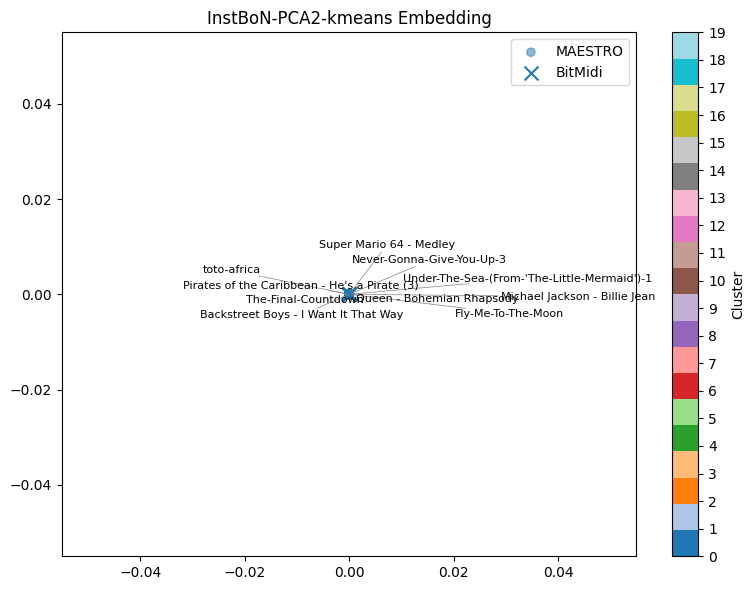

Running: InstBoN-Iso2-kmeans
Error in InstBoN-PCA2-kmeans: ARPACK error -9: Starting vector is zero.


In [54]:
results = {}
bitmidi_cluster_results = {}
cluster_dfs = {}

for vec_name, vectorizer in vectorizers:
    maestro_data = pretty_train if vec_name == 'InstBoN' else train_loaded
    val_data = pretty_val if vec_name == 'InstBoN' else val_loaded
    bitmidi_data = bitmidi_pretty if vec_name == 'InstBoN' else bitmidi_raw

    for red_name, reducer in reducers:
        for clust_name, clusterer in clusterers:
            print(f'Running: {vec_name}-{red_name}-{clust_name}')
            model = Pipeline([
                (vec_name, vectorizer),
                (red_name, reducer),
                (clust_name, clusterer)
            ])
            model = clone(model)

            try:
                model.fit(maestro_data)
                val_embeddings = model[:2].transform(val_data)
                val_preds = model.named_steps[clust_name].predict(val_embeddings)
                score = evaluation.evaluate_clusters(val_preds, validate[['canonical_composer']])
                key = f'{vec_name}-{red_name}-{clust_name}'
                results[key] = score
                bitmidi_embeds = model[:2].transform(bitmidi_data)
                bitmidi_clusters = model.named_steps[clust_name].predict(bitmidi_embeds)
                bitmidi_cluster_results[key] = bitmidi_clusters
                cmap = cm.get_cmap('tab20')
                norm = Normalize(vmin=0, vmax=19)
                fig, ax = plt.subplots(figsize=(8, 6))
                sc = ax.scatter(
                    val_embeddings[:, 0], val_embeddings[:, 1],
                    c=val_preds,
                    cmap=cmap,
                    norm=norm,
                    alpha=0.5,
                    label='MAESTRO'
                )
                texts = []
                for i, (x, y) in enumerate(bitmidi_embeds):
                    ax.scatter(
                        x, y,
                        color=cmap(norm(bitmidi_clusters[i])),
                        marker='x',
                        s=100,
                        label='BitMidi' if i == 0 else ""
                    )
                    texts.append(ax.text(x, y, bitmidi_files[i].replace('.mid', ''), fontsize=8))
                adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
                ax.set_title(f"{key} Embedding")
                ax.legend(loc='upper right')
                sm = cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                fig.colorbar(sm, ax=ax, ticks=range(20), label='Cluster')
                plt.tight_layout()
                plt.show()

                cluster_rows = []
                for i, cluster in enumerate(val_preds):
                    cluster_rows.append({
                        'cluster': cluster,
                        'source': 'maestro',
                        'song': validate.iloc[i]['canonical_title'],
                        'filename': validate.iloc[i]['midi_filename']
                    })
                for i, cluster in enumerate(bitmidi_clusters):
                    cluster_rows.append({
                        'cluster': cluster,
                        'source': 'bitmidi',
                        'song': bitmidi_files[i].replace('.mid', ''),
                        'filename': bitmidi_files[i]
                    })
                cluster_df = pd.DataFrame(cluster_rows).sort_values(by=['cluster', 'source'])
                cluster_dfs[key] = cluster_df  # Save this model's clusters by key for export later

            except Exception as e:
                print(f"Error in {key}: {e}")

In [56]:
with pd.ExcelWriter("bitmidi_cluster_results.xlsx", engine="xlsxwriter") as writer:
    for key, df in cluster_dfs.items():
        sheet_name = key[:31]  
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [57]:
scores_df = pd.DataFrame([
    {'model': key, **value}
    for key, value in results.items()
])
if 'canonical_composer' in scores_df.columns:
    scores_df = scores_df.rename(columns={'canonical_composer': 'homogeneity'})

scores_df = scores_df.sort_values(by='homogeneity', ascending=False)
scores_df

,model,homogeneity
2,BoNn-PCA2-kmeans,0.466363
7,BoC2-Iso2-kmeans,0.461241
0,BoN-PCA2-kmeans,0.445494
3,BoNn-Iso2-kmeans,0.441249
4,NfIsf-PCA2-kmeans,0.440064
6,BoC2-PCA2-kmeans,0.432616
5,NfIsf-Iso2-kmeans,0.393126
1,BoN-Iso2-kmeans,0.390943
8,InstBoN-PCA2-kmeans,0.000000


**Comparing songs in same clusters visually for BoNn-PCA2-kmeans:**

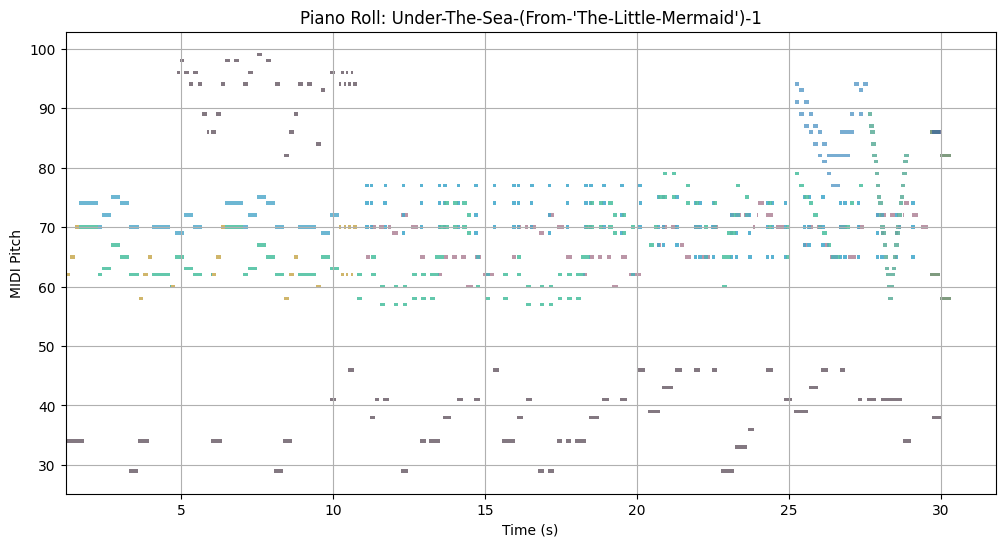

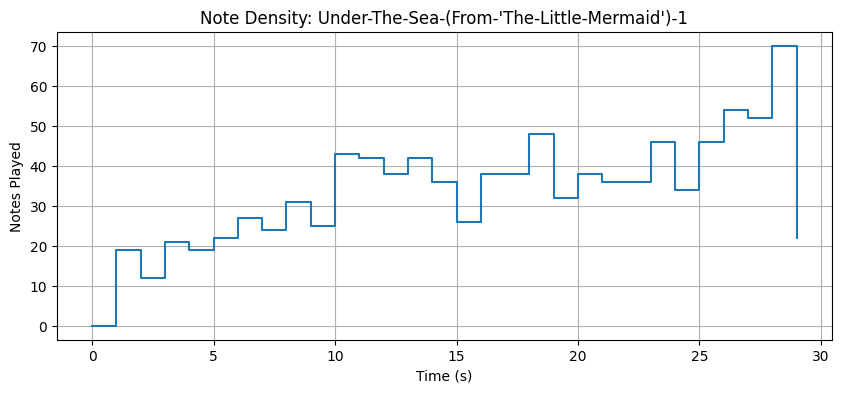

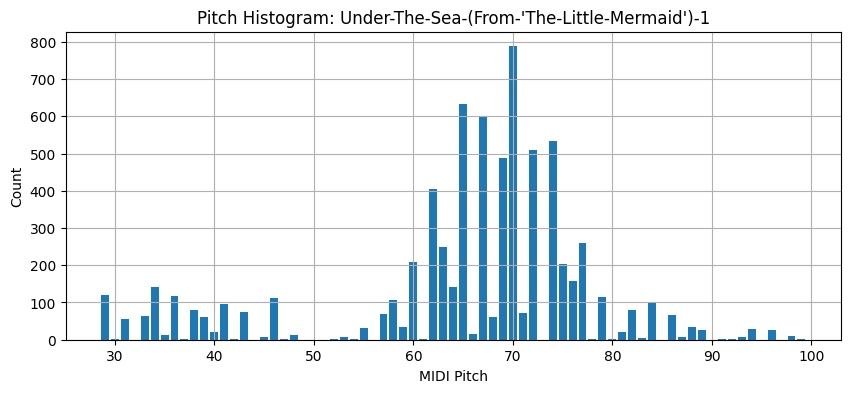

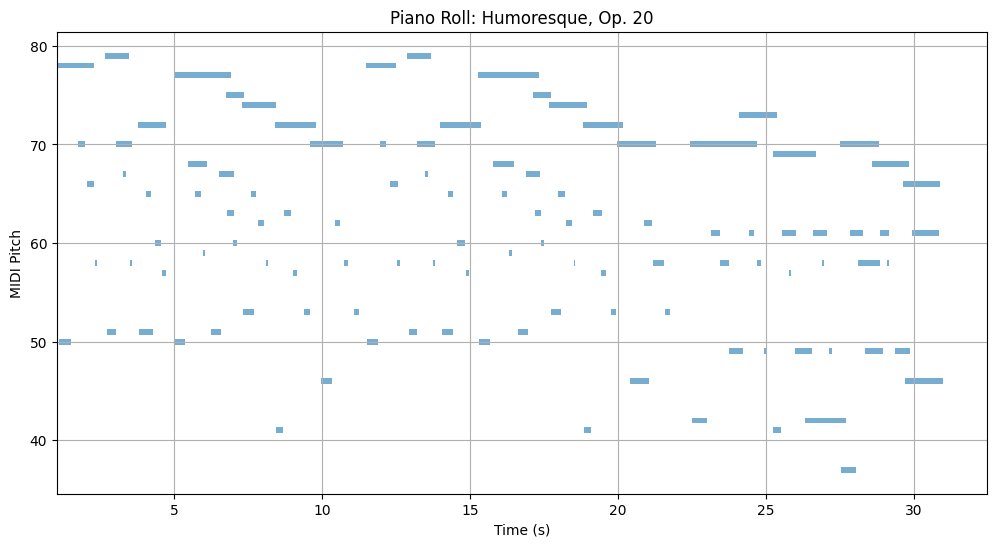

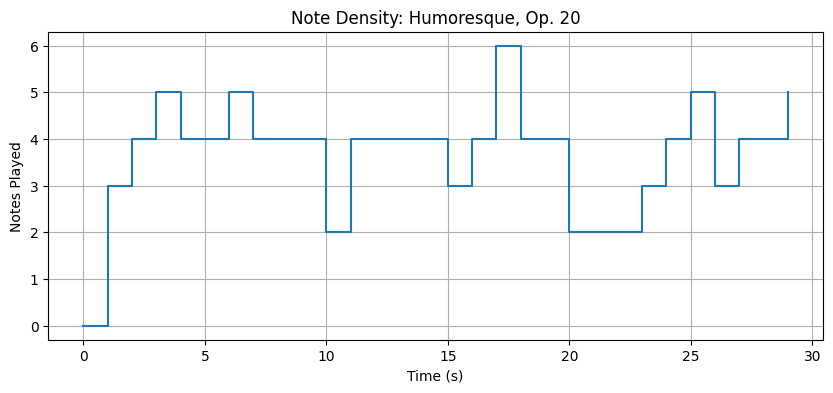

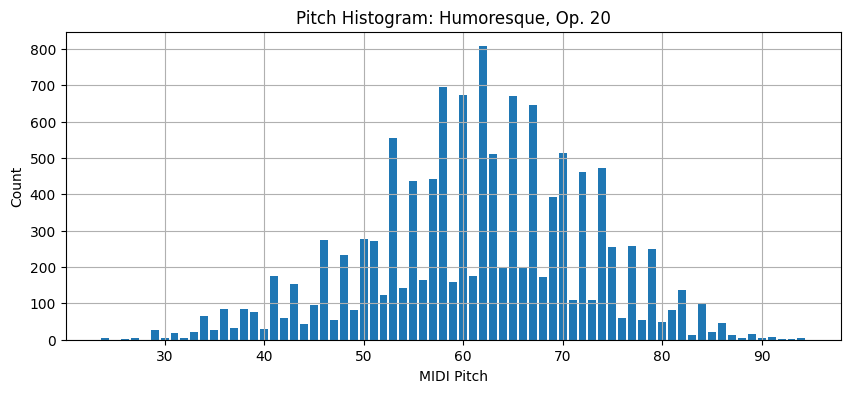

In [ ]:
from visualizations import plot_piano_roll, plot_note_density, plot_pitch_histogram, visualize_song

bitmidi_map = dict(zip(bitmidi_files, bitmidi_pretty))
maestro_map = dict(zip(validate['midi_filename'], pretty_val))

#cluster 3
visualize_song("Under-The-Sea-(From-'The-Little-Mermaid')-1", cluster_df, bitmidi_map, maestro_map)
visualize_song("Humoresque, Op. 20", cluster_df, bitmidi_map, maestro_map)

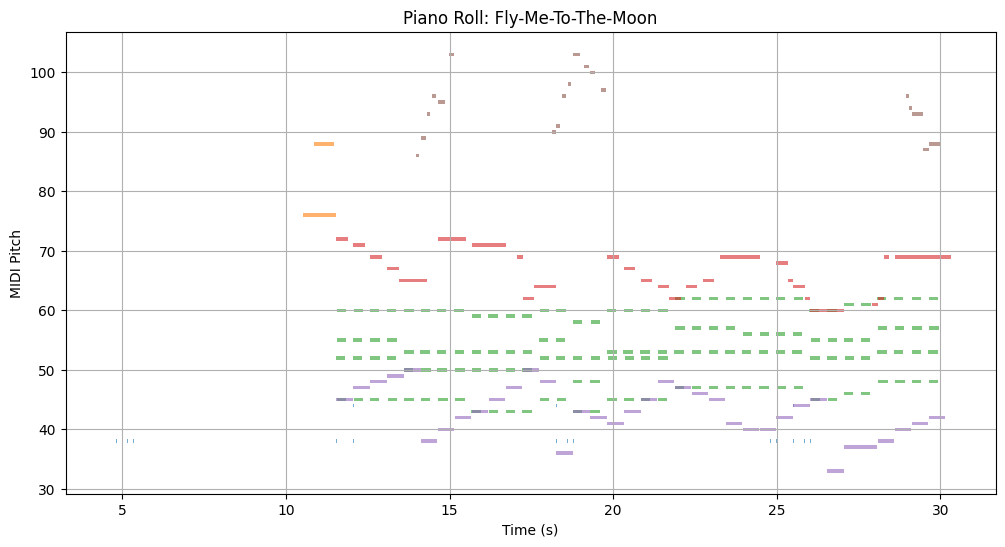

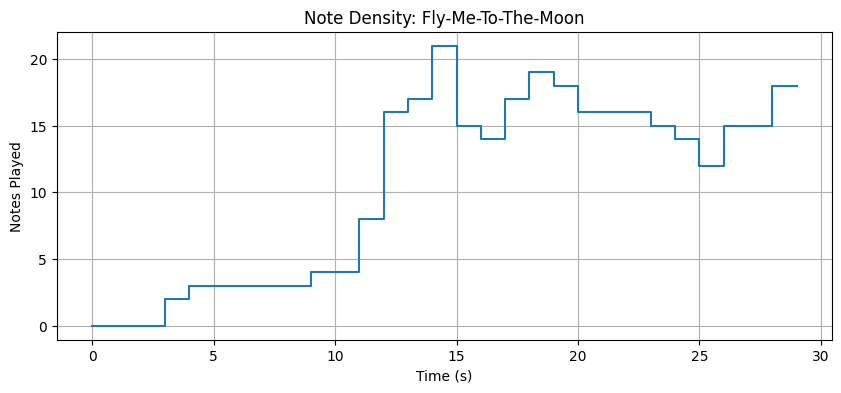

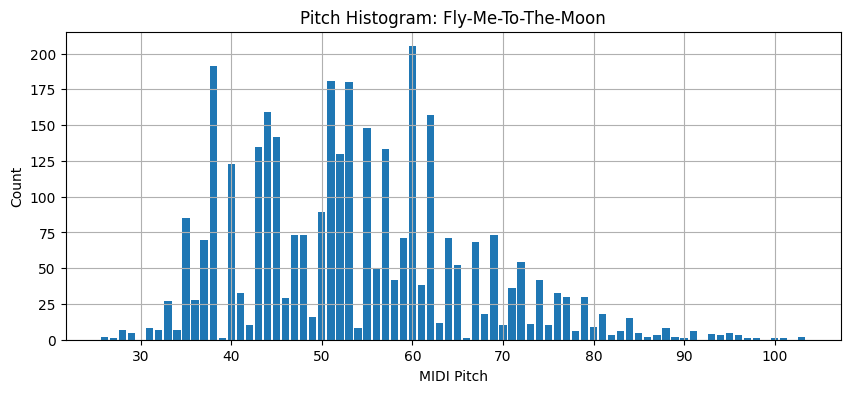

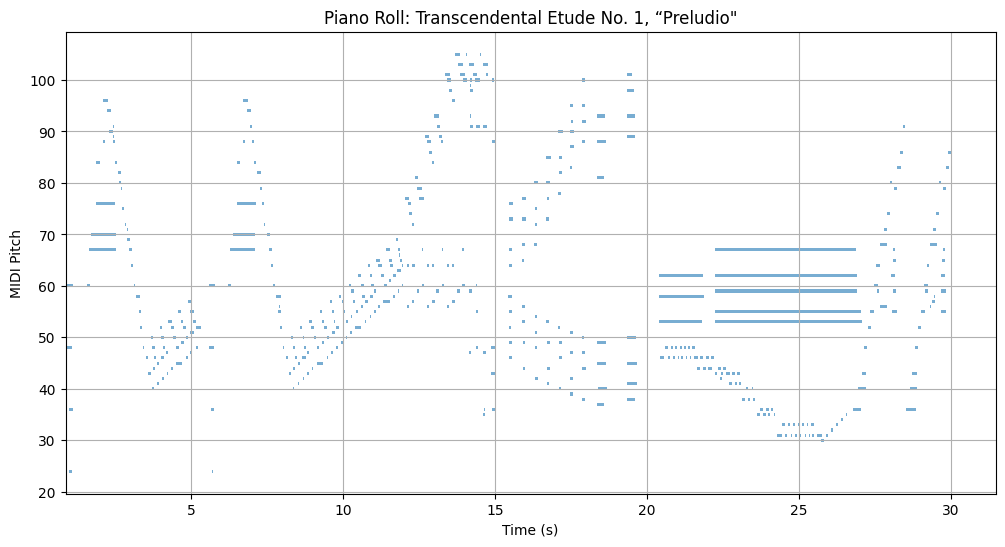

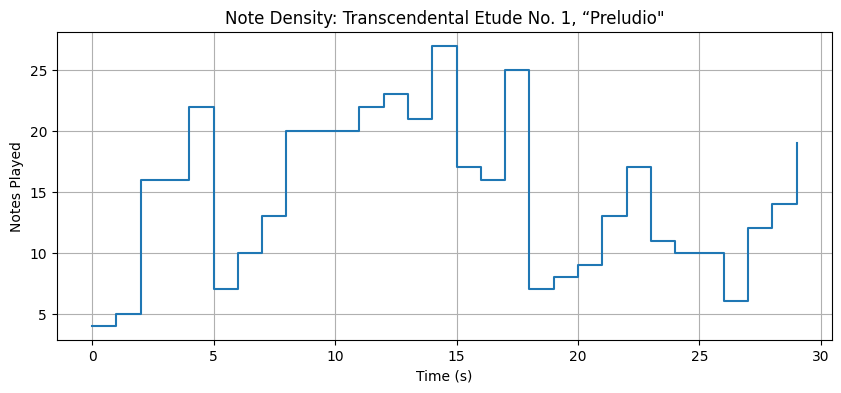

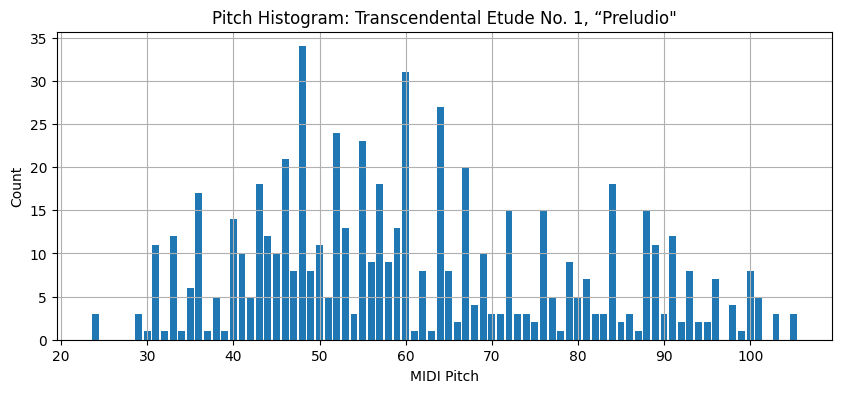

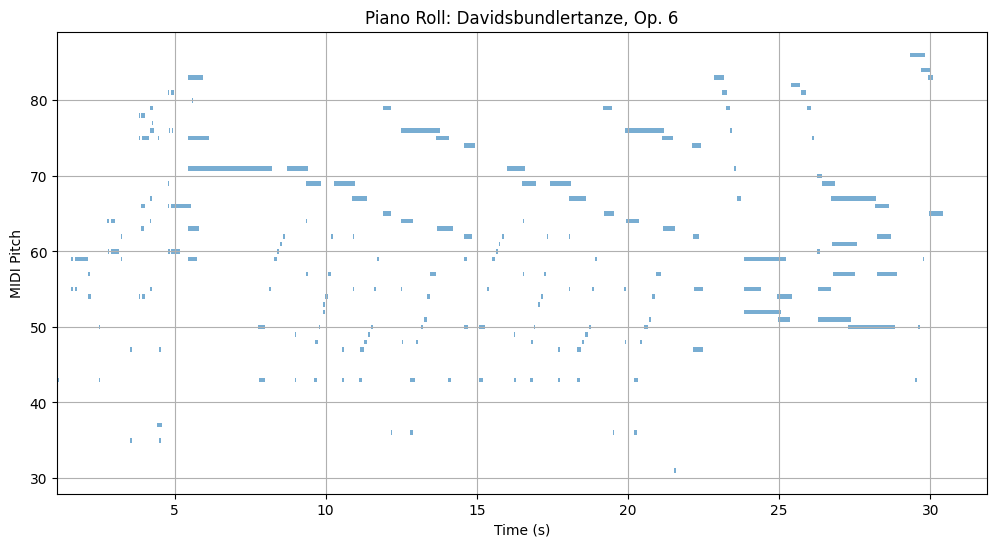

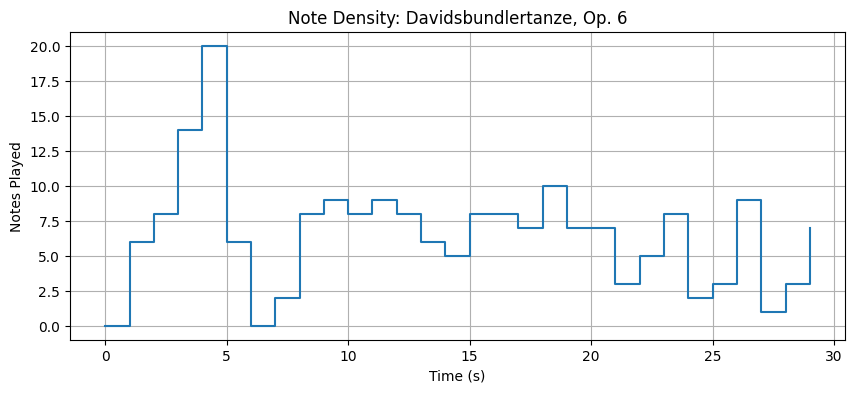

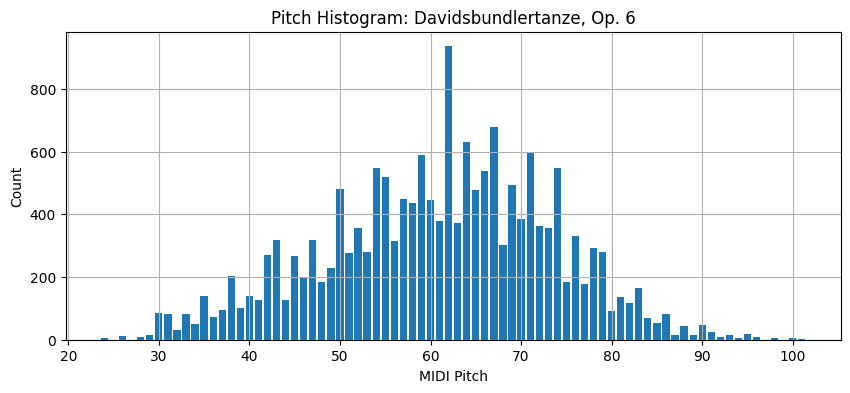

In [ ]:
#cluster 4
visualize_song("Fly-Me-To-The-Moon", cluster_df, bitmidi_map, maestro_map)
visualize_song('Transcendental Etude No. 1, “Preludio"', cluster_df, bitmidi_map, maestro_map)
visualize_song("Davidsbundlertanze, Op. 6", cluster_df, bitmidi_map, maestro_map)

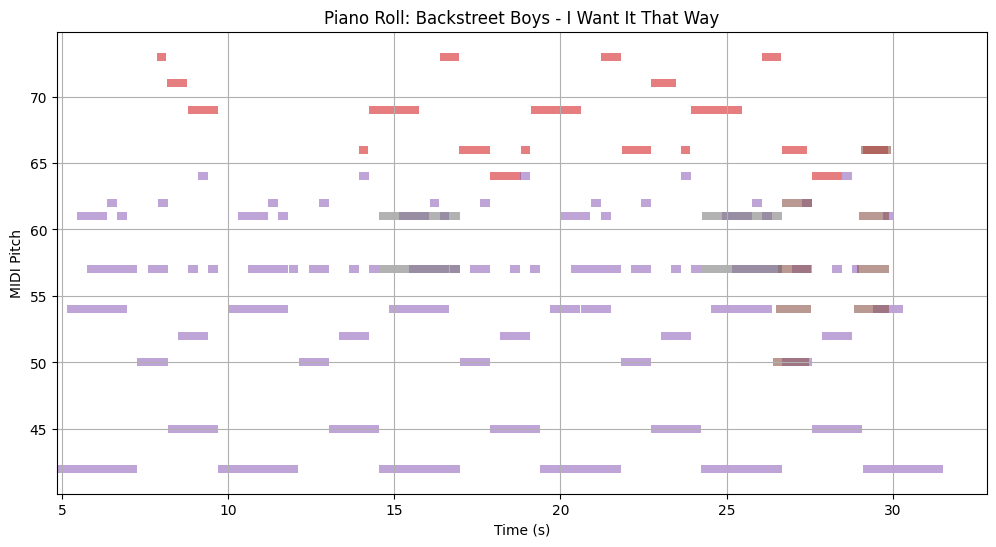

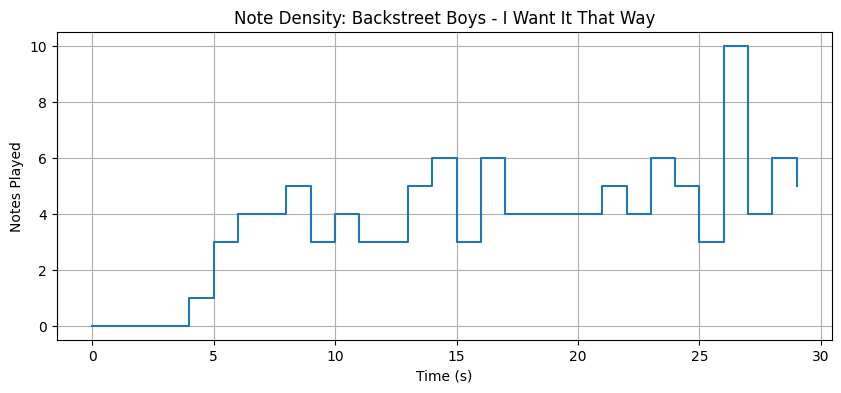

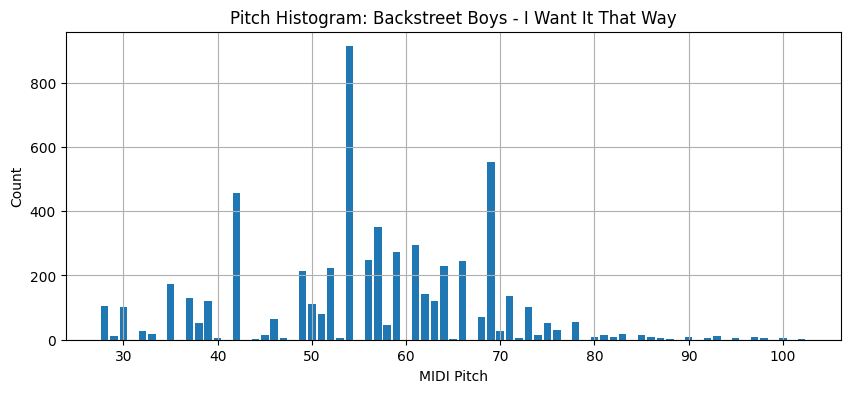

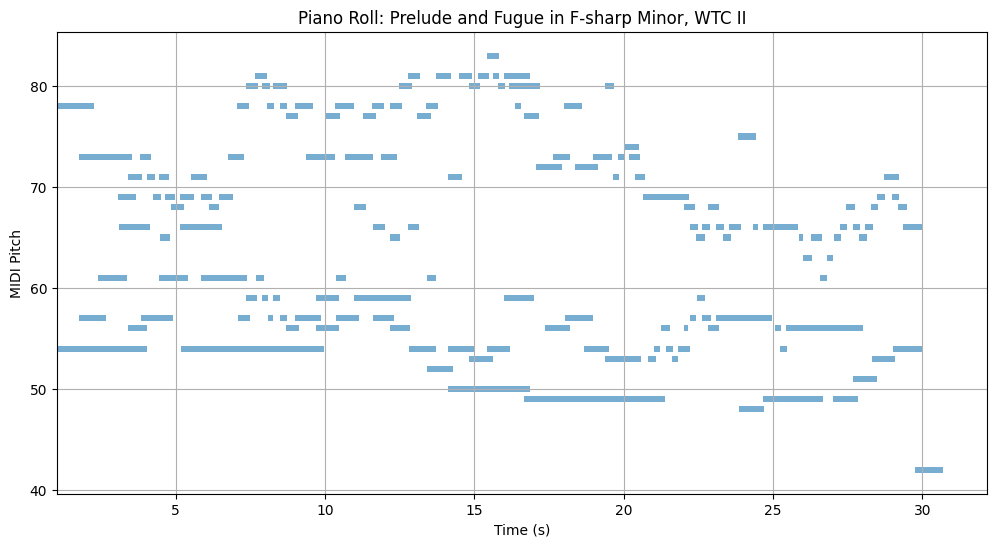

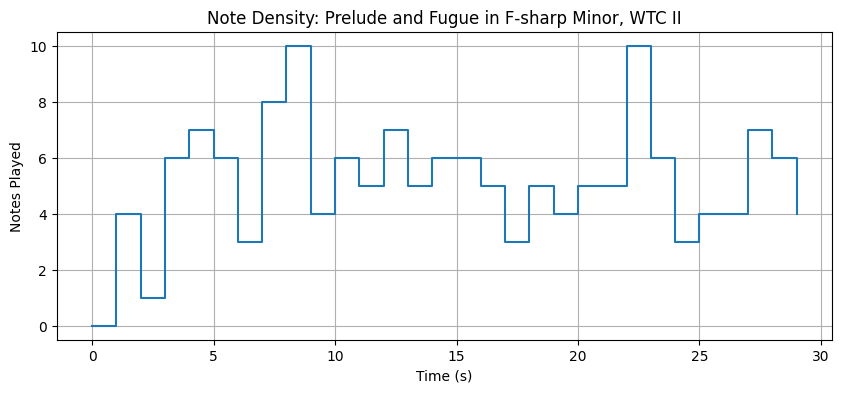

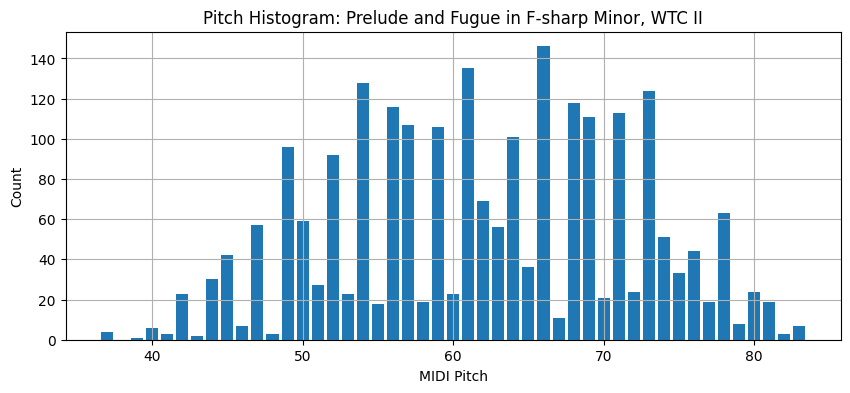

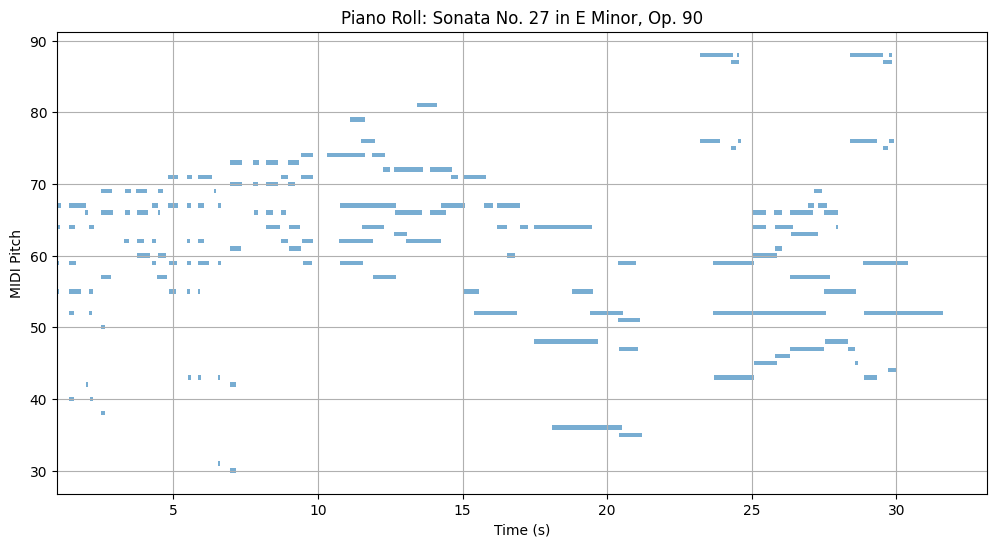

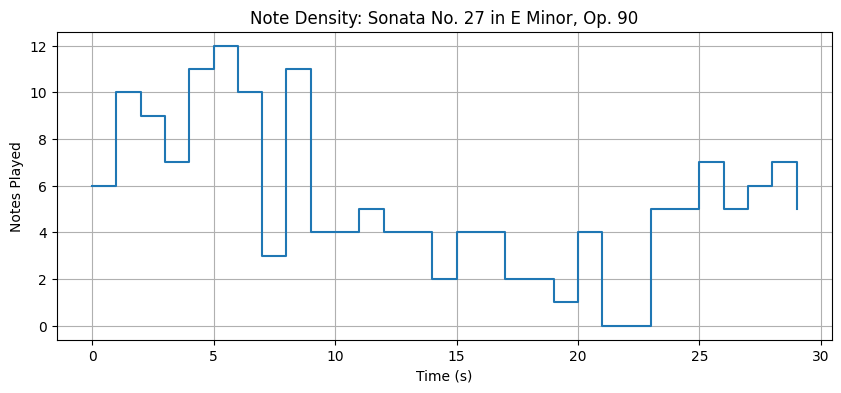

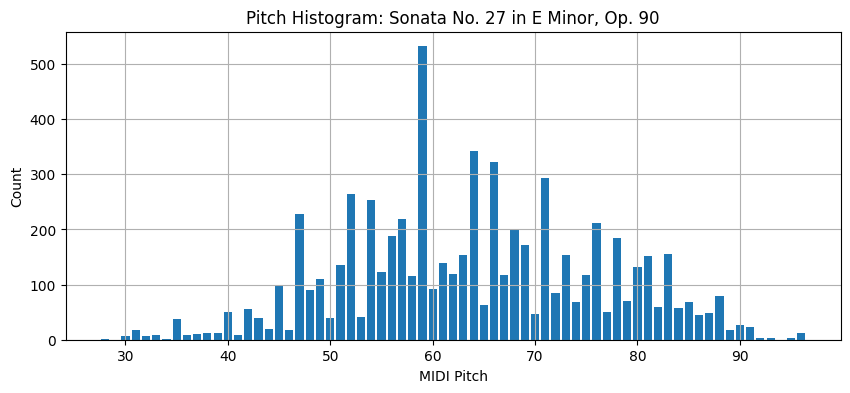

In [ ]:
#cluster 7
visualize_song("Backstreet Boys - I Want It That Way", cluster_df, bitmidi_map, maestro_map)
visualize_song('Prelude and Fugue in F-sharp Minor, WTC II', cluster_df, bitmidi_map, maestro_map)
visualize_song("Sonata No. 27 in E Minor, Op. 90", cluster_df, bitmidi_map, maestro_map)

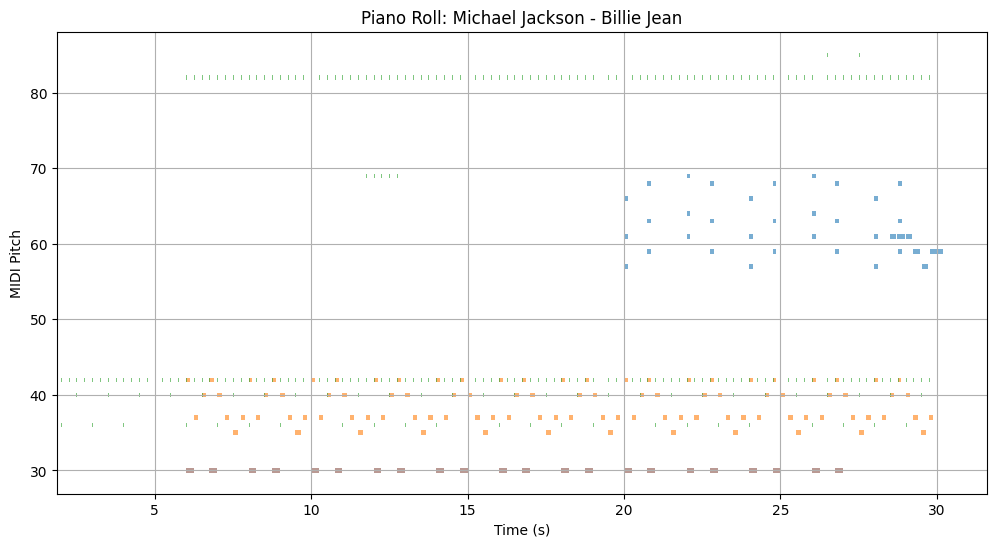

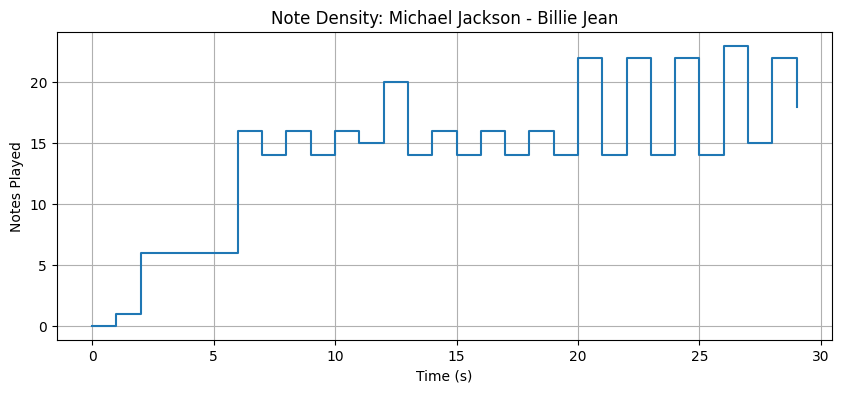

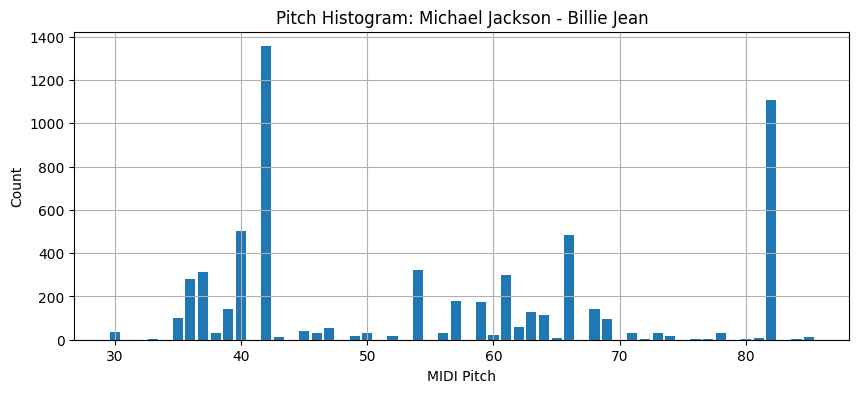

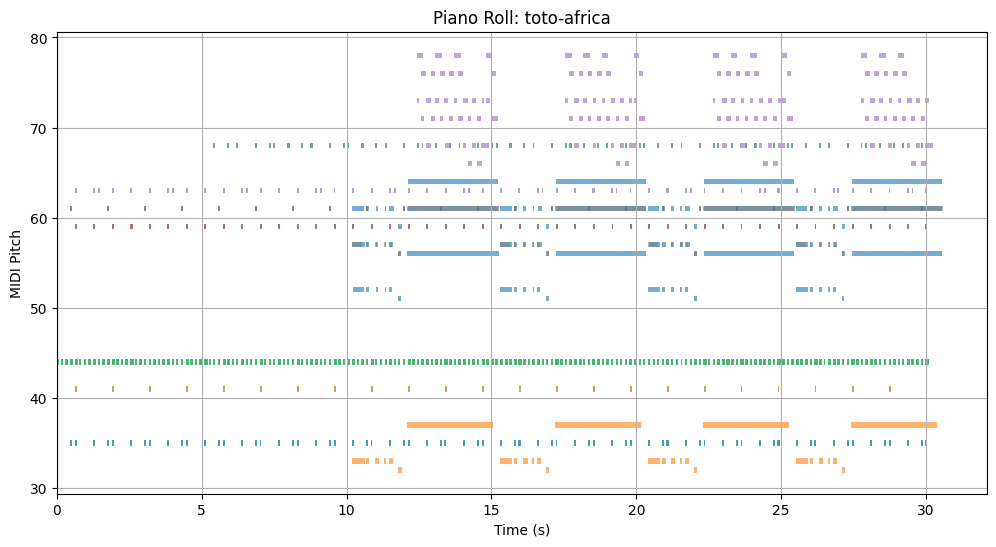

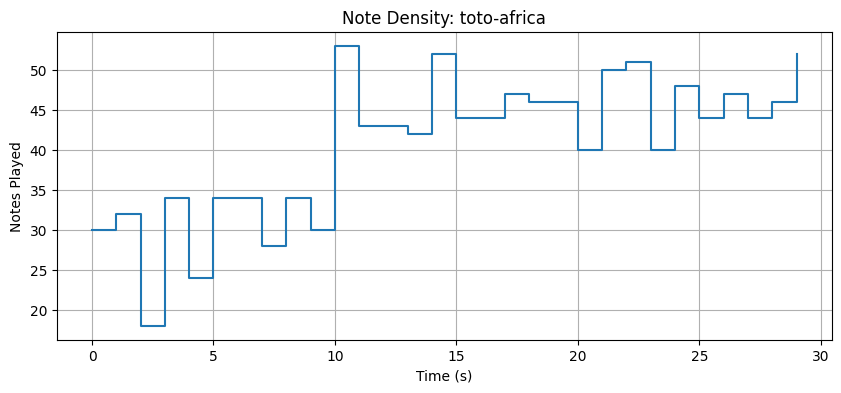

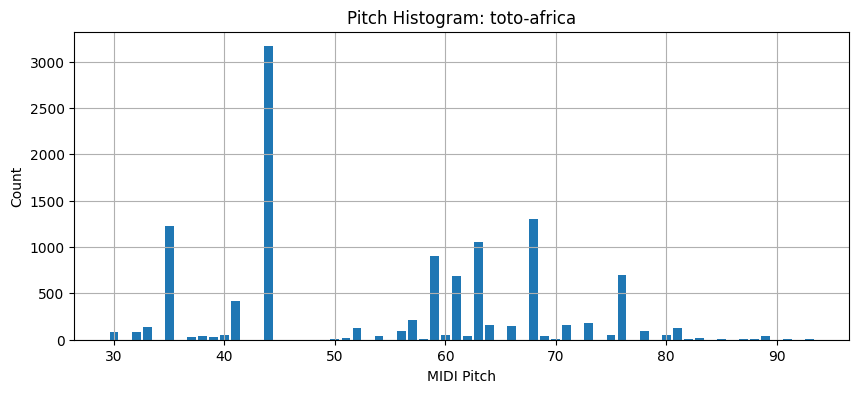

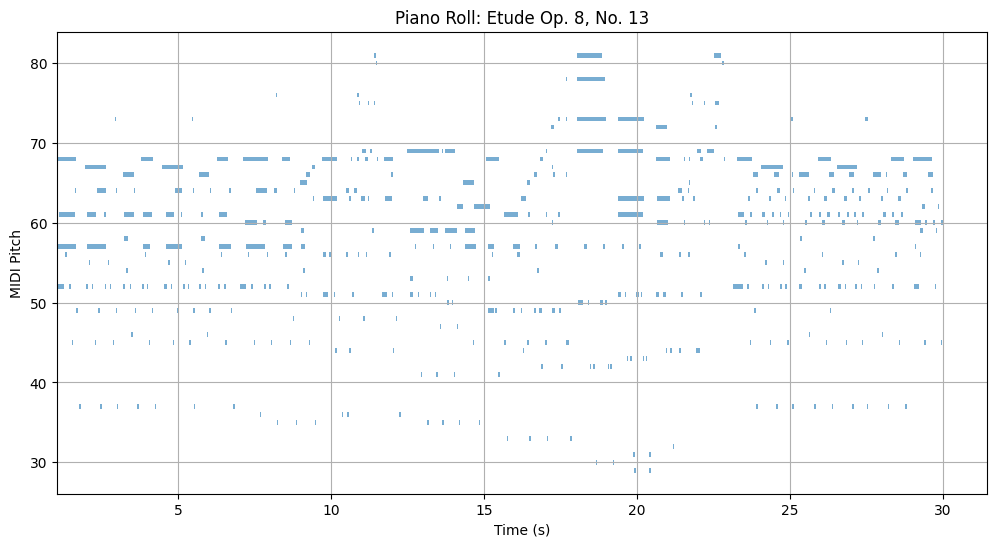

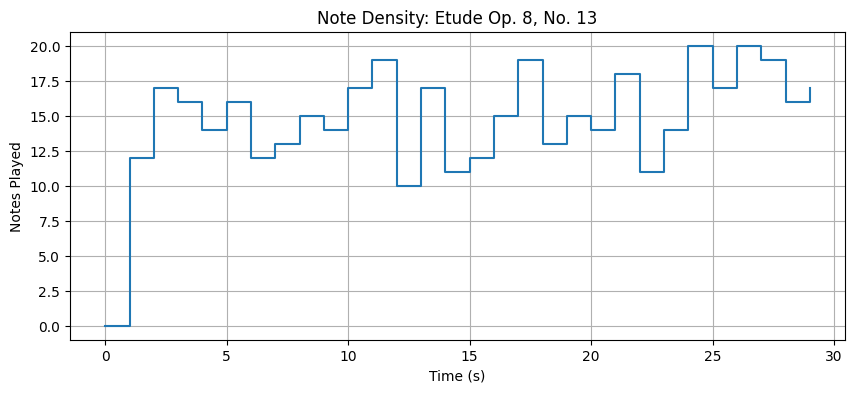

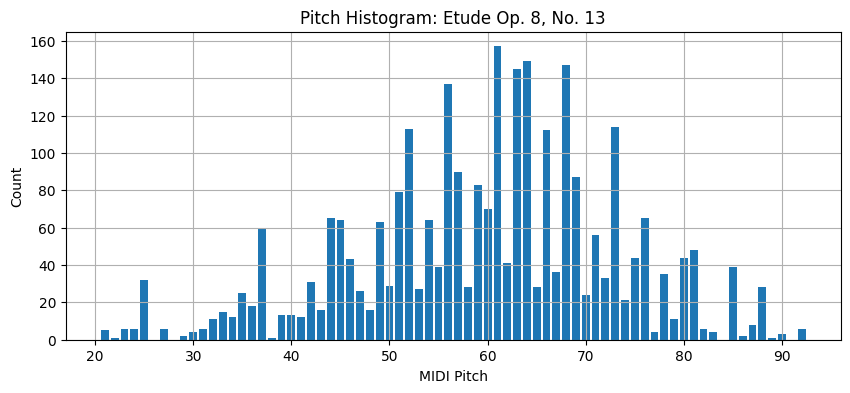

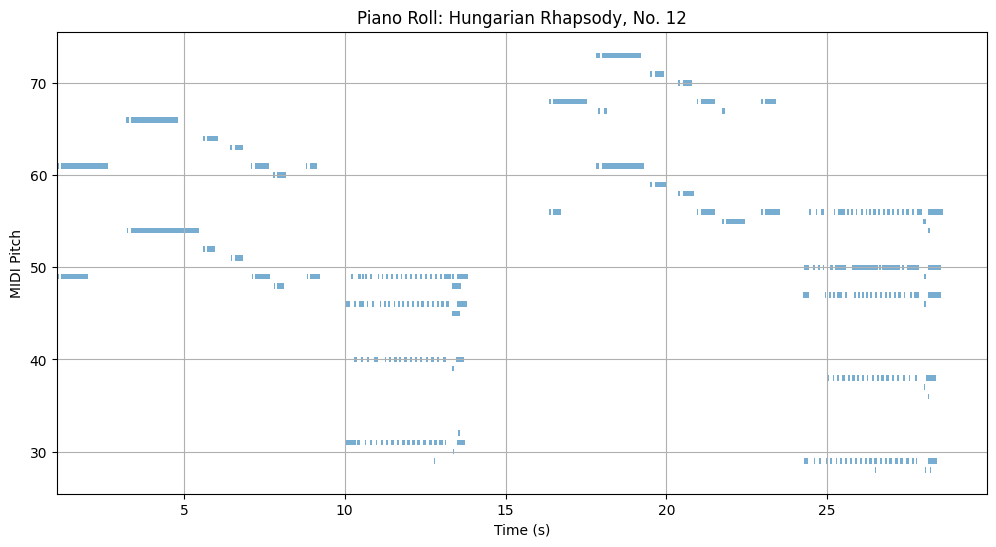

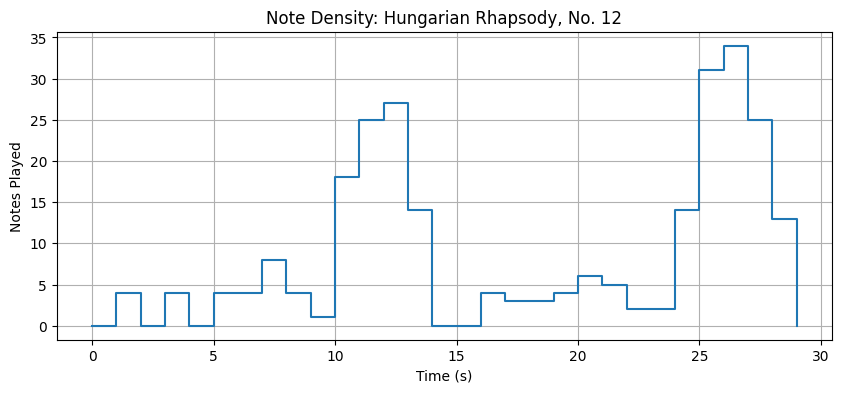

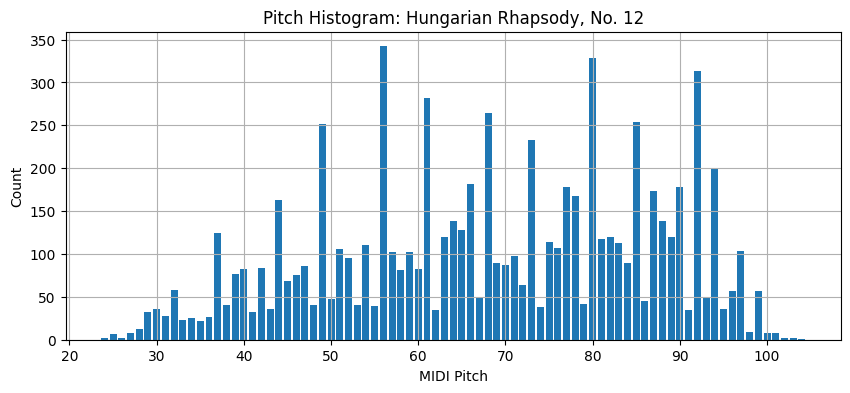

In [ ]:
#cluster 11
visualize_song("Michael Jackson - Billie Jean", cluster_df, bitmidi_map, maestro_map)
visualize_song("toto-africa", cluster_df, bitmidi_map, maestro_map)
visualize_song('Etude Op. 8, No. 13', cluster_df, bitmidi_map, maestro_map)
visualize_song("Hungarian Rhapsody, No. 12", cluster_df, bitmidi_map, maestro_map)

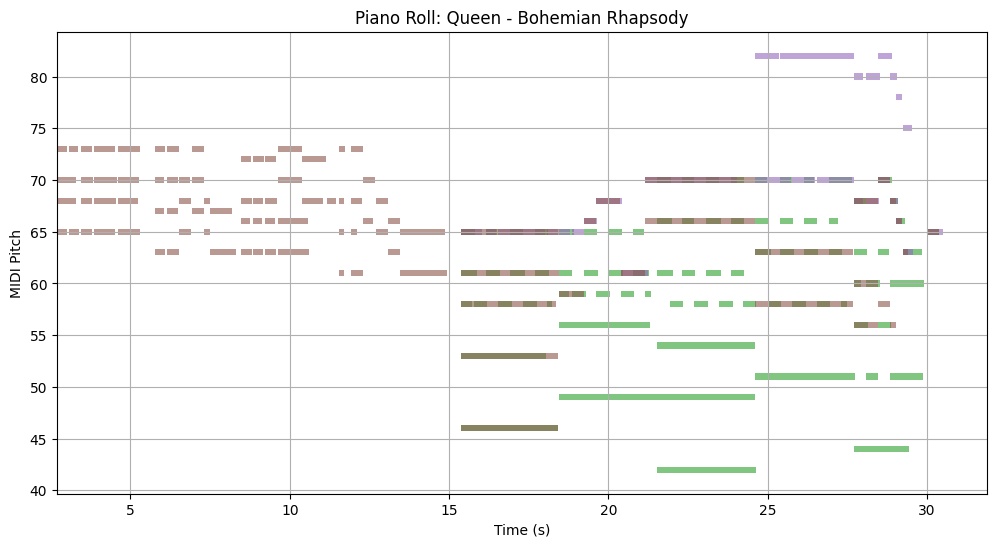

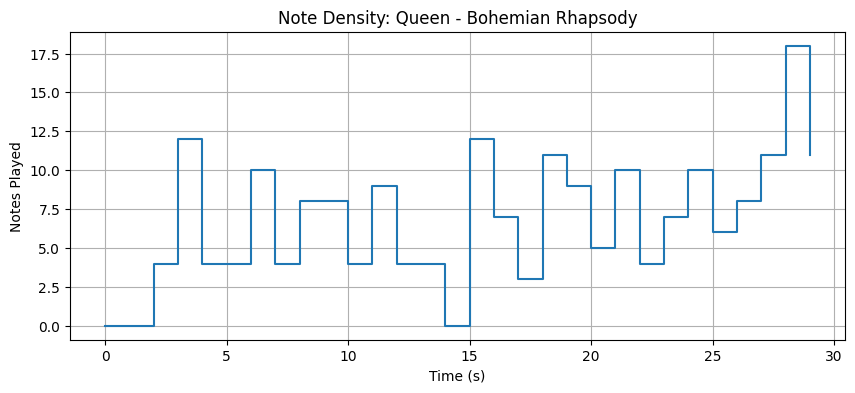

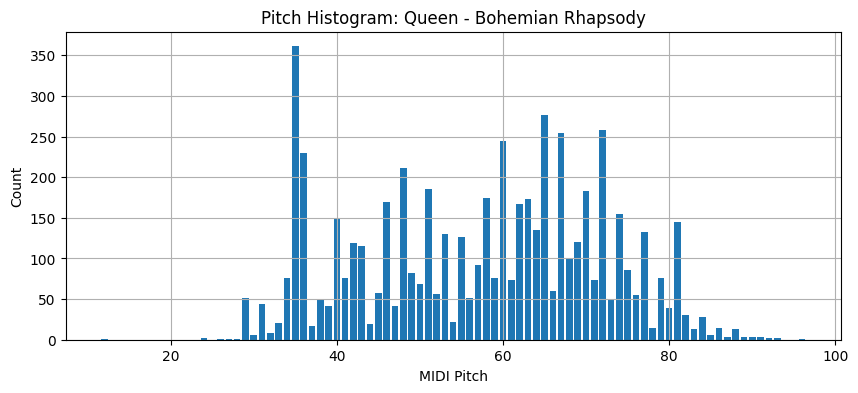

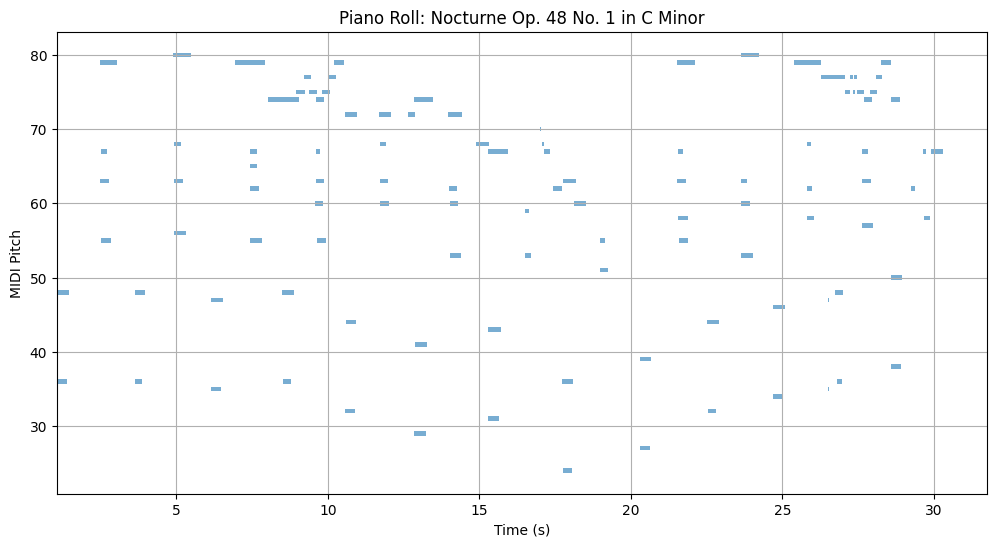

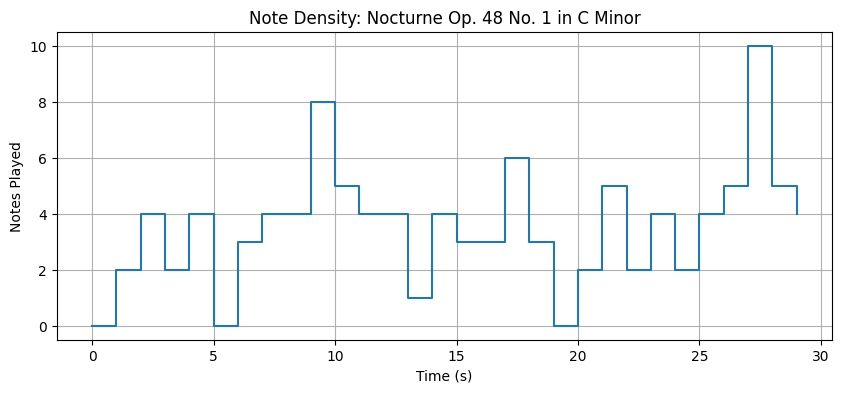

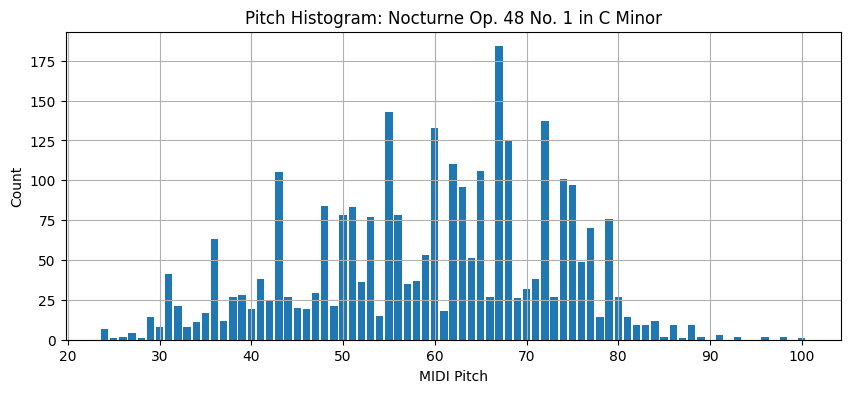

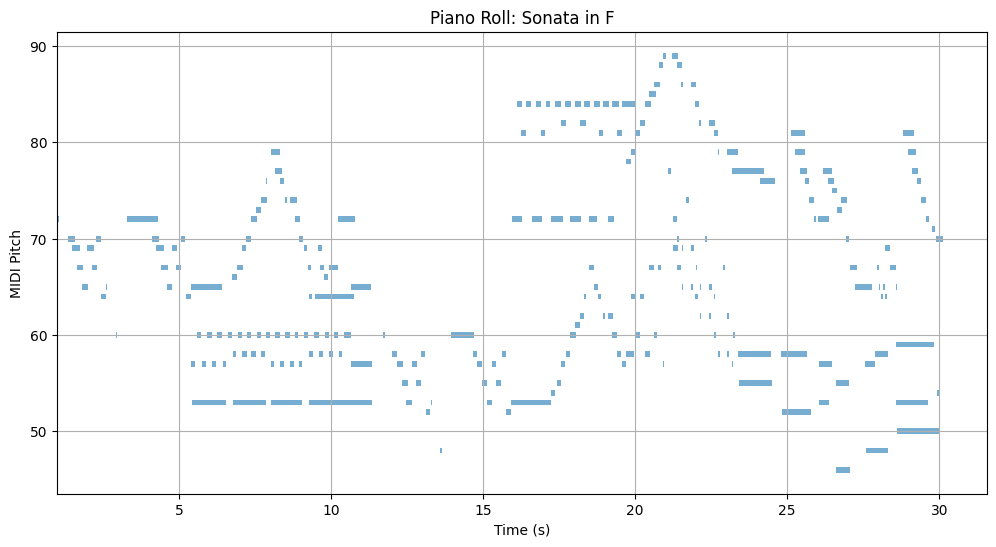

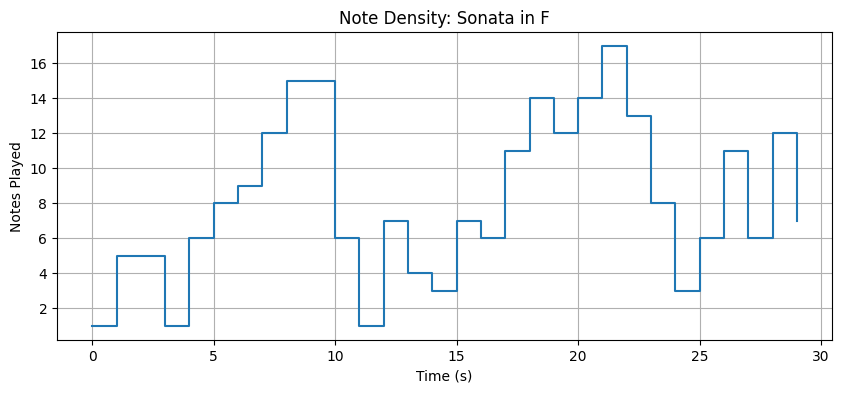

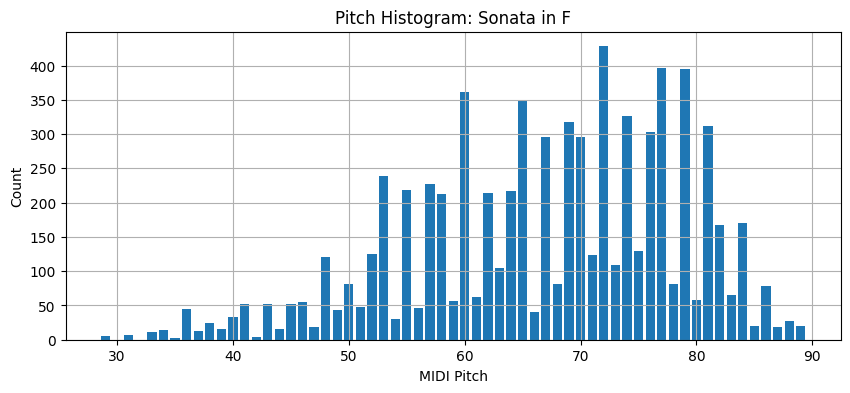

In [70]:
visualize_song("Queen - Bohemian Rhapsody", cluster_df, bitmidi_map, maestro_map)
visualize_song("Nocturne Op. 48 No. 1 in C Minor", cluster_df, bitmidi_map, maestro_map)
visualize_song("Sonata in F", cluster_df, bitmidi_map, maestro_map)